Method 4: Regime Switching Detection
Common stocks: 45

COMPUTING STOCK-LEVEL METRICS

1. Normal days...
Processing 45 stocks for 2010-01-04...
✓ Processed 45/45 stocks
Processing 45 stocks for 2010-01-05...
✓ Processed 45/45 stocks
Processing 45 stocks for 2010-01-06...
✓ Processed 45/45 stocks

2. Flash crash day...
Processing 45 stocks for 2010-05-06...
✓ Processed 45/45 stocks

✓ Normal days: 135 observations
✓ Crash day: 45 observations

REGIME CLASSIFICATION

Normal Days:
regime
Neutral      102
Fragile       33
Resilient      0
Name: count, dtype: int64
Fragile: 24.4%

Flash Crash Day:
regime
Fragile      41
Neutral       4
Resilient     0
Name: count, dtype: int64
Fragile: 91.1%
→ Increase: +66.7 pp

INTRADAY TIMELINE

Processing 2010-01-04 in 5-min windows...
  Window 20/144
  Window 40/144
  Window 60/144
  Window 80/144
  Window 100/144
  Window 120/144
  Window 140/144
  ✓ Completed 81 windows

Processing 2010-05-06 in 5-min windows...
  Window 20/156
  Window 40/156
  Wind

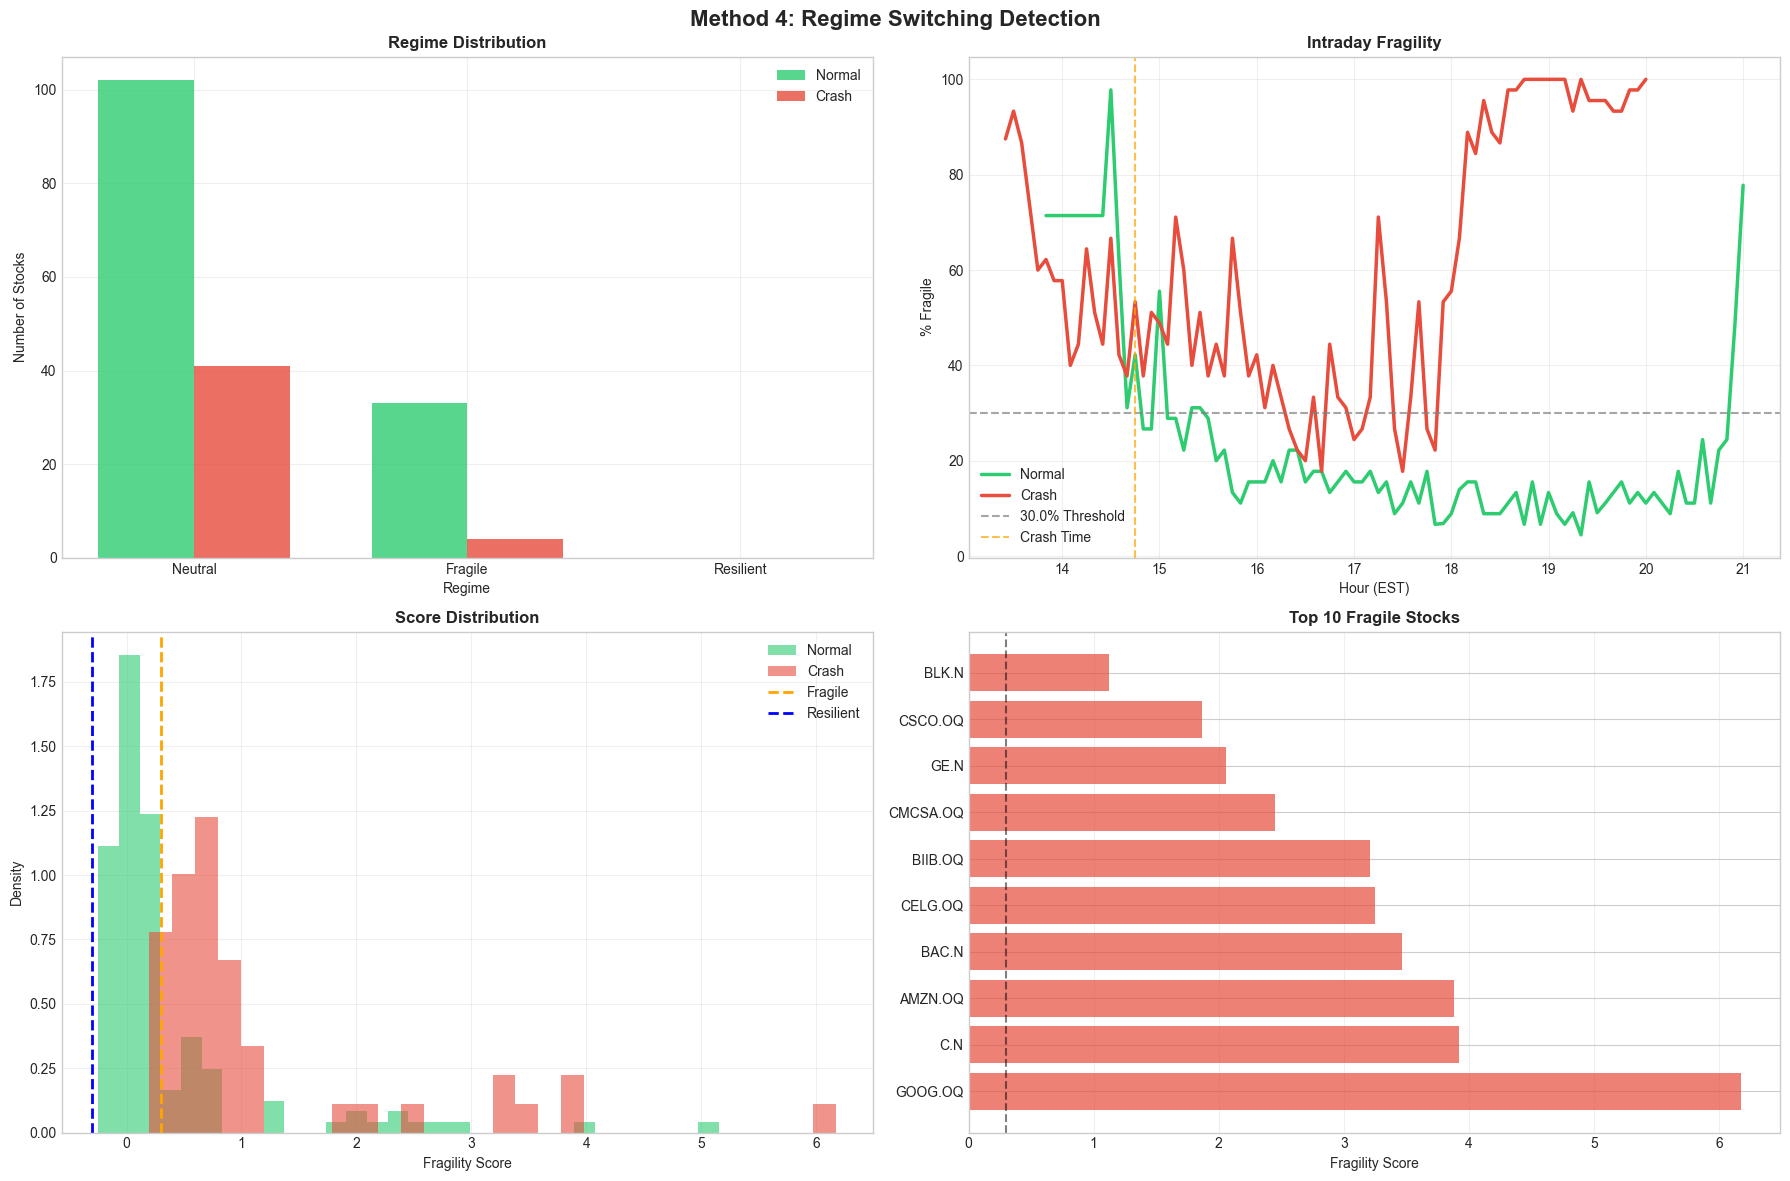

✓ Saved visualization

SUMMARY STATISTICS

     Period  Total  Resilient  Neutral  Fragile  Fragile_%
Normal Days    135          0      102       33       24.4
Flash Crash     45          0        4       41       91.1

Top 20 Fragile Stocks:
  ticker  fragility_score  mean_spread  total_depth  mid_volatility  regime
 GOOG.OQ           6.1748       0.0045       5.1371          1.8307 Fragile
     C.N           3.9182       0.0030   13111.6424          0.0479 Fragile
 AMZN.OQ           3.8782       0.0025       4.0497          4.0407 Fragile
   BAC.N           3.4624       0.0008     390.0816          0.0128 Fragile
 CELG.OQ           3.2436       0.0020       8.6008         58.4430 Fragile
 BIIB.OQ           3.2078       0.0016       9.0880         76.8737 Fragile
CMCSA.OQ           2.4470       0.0009     131.7270         42.5388 Fragile
    GE.N           2.0532       0.0008     236.2294          0.0187 Fragile
 CSCO.OQ           1.8686       0.0007     157.2155          3.6687 Frag

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print("Method 4: Regime Switching Detection")
print("="*80)

# Configuration
DATA_DIR = Path("/Users/karine/Downloads/US_flash_crash")
flash_crash_date = "2010-05-06"
normal_dates = ["2010-01-04", "2010-01-05", "2010-01-06"]
OUTPUT_DIR = Path("../results/method4")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Data loading functions
def get_all_stocks_with_data(date):
    bbo_dir = DATA_DIR / "bbo"
    stocks_with_data = []
    for folder in bbo_dir.iterdir():
        if folder.is_dir() and not folder.name.startswith('.'):
            ticker = folder.name
            file_path = folder / f"{date}-{ticker}-bbo.parquet"
            if file_path.exists():
                stocks_with_data.append(ticker)
    return sorted(stocks_with_data)

def load_bbo_data(ticker, date):
    try:
        file_path = DATA_DIR / "bbo" / ticker / f"{date}-{ticker}-bbo.parquet"
        if file_path.exists():
            return pd.read_parquet(file_path)
    except:
        pass
    return None

def load_trade_data(ticker, date):
    try:
        file_path = DATA_DIR / "trade" / ticker / f"{date}-{ticker}-trade.parquet"
        if file_path.exists():
            return pd.read_parquet(file_path)
    except:
        pass
    return None

# Get common stocks
stocks_normal = get_all_stocks_with_data(normal_dates[0])
stocks_crash = get_all_stocks_with_data(flash_crash_date)
stocks_common = list(set(stocks_normal) & set(stocks_crash))
print(f"Common stocks: {len(stocks_common)}")

# Liquidity metrics
def compute_liquidity_metrics_full(df_bbo, df_trade=None):
    df_clean = df_bbo[(df_bbo['bid-price'] > 0) & (df_bbo['ask-price'] > 0)].copy()
    if len(df_clean) < 50:
        return None
    
    metrics = {}
    df_clean['spread'] = df_clean['ask-price'] - df_clean['bid-price']
    mid_price = (df_clean['ask-price'] + df_clean['bid-price']) / 2
    df_clean['rel_spread'] = df_clean['spread'] / mid_price
    
    metrics['mean_spread'] = df_clean['rel_spread'].mean()
    metrics['std_spread'] = df_clean['rel_spread'].std()
    metrics['median_spread'] = df_clean['rel_spread'].median()
    metrics['mean_bid_volume'] = df_clean['bid-volume'].mean()
    metrics['mean_ask_volume'] = df_clean['ask-volume'].mean()
    metrics['total_depth'] = (df_clean['bid-volume'] + df_clean['ask-volume']).mean()
    metrics['depth_std'] = (df_clean['bid-volume'] + df_clean['ask-volume']).std()
    
    total_volume = df_clean['bid-volume'] + df_clean['ask-volume']
    df_clean['imbalance'] = (df_clean['bid-volume'] - df_clean['ask-volume']) / total_volume.replace(0, np.nan)
    metrics['abs_mean_imbalance'] = df_clean['imbalance'].abs().mean()
    metrics['num_updates'] = len(df_clean)
    time_range = (df_clean['xltime'].max() - df_clean['xltime'].min()) * 24 * 60
    metrics['update_rate'] = len(df_clean) / time_range if time_range > 0 else 0
    
    df_clean['mid_price'] = mid_price
    df_clean['mid_returns'] = df_clean['mid_price'].pct_change()
    metrics['mid_volatility'] = df_clean['mid_returns'].std() * np.sqrt(252 * 390)
    
    return metrics

# Regime classification
metrics_cols = ['mean_spread', 'std_spread', 'total_depth', 'depth_std', 
                'abs_mean_imbalance', 'num_updates', 'update_rate', 'mid_volatility']

def classify_regime_advanced(metrics_df, reference_df=None):
    df = metrics_df.copy()
    ref_df = reference_df if reference_df is not None else df
    
    for col in metrics_cols:
        if col in df.columns:
            ref_median = ref_df[col].median()
            ref_std = ref_df[col].std()
            df[f'{col}_norm'] = (df[col] - ref_median) / (ref_std + 1e-10)
    
    df['spread_fragility'] = df['mean_spread_norm'] + df['std_spread_norm']
    df['depth_fragility'] = -df['total_depth_norm'] + df['depth_std_norm']
    df['activity_fragility'] = df['update_rate_norm'] + df['mid_volatility_norm']
    df['imbalance_fragility'] = df['abs_mean_imbalance_norm']
    
    df['fragility_score'] = (
        df['spread_fragility'] * 0.35 +
        df['depth_fragility'] * 0.30 +
        df['activity_fragility'] * 0.25 +
        df['imbalance_fragility'] * 0.10
    )
    
    df['regime'] = pd.cut(df['fragility_score'], 
                          bins=[-np.inf, -0.3, 0.3, np.inf],
                          labels=['Resilient', 'Neutral', 'Fragile'])
    return df

# Compute market metrics
def compute_market_metrics(date, stocks):
    results = []
    print(f"Processing {len(stocks)} stocks for {date}...")
    for i, ticker in enumerate(stocks):
        if (i + 1) % 50 == 0:
            print(f"  Progress: {i+1}/{len(stocks)}")
        try:
            df_bbo = load_bbo_data(ticker, date)
            df_trade = load_trade_data(ticker, date)
            if df_bbo is not None:
                metrics = compute_liquidity_metrics_full(df_bbo, df_trade)
                if metrics is not None:
                    metrics['ticker'] = ticker
                    metrics['date'] = date
                    results.append(metrics)
        except:
            continue
    print(f"✓ Processed {len(results)}/{len(stocks)} stocks")
    return pd.DataFrame(results)

print("\nCOMPUTING STOCK-LEVEL METRICS")
print("="*80)

# Normal days
print("\n1. Normal days...")
normal_results = []
for date in normal_dates:
    df_temp = compute_market_metrics(date, stocks_common)
    normal_results.append(df_temp)
df_normal_full = pd.concat(normal_results, ignore_index=True)

# Crash day
print("\n2. Flash crash day...")
df_crash_full = compute_market_metrics(flash_crash_date, stocks_common)

print(f"\n✓ Normal days: {len(df_normal_full)} observations")
print(f"✓ Crash day: {len(df_crash_full)} observations")

# Classify regimes
print("\nREGIME CLASSIFICATION")
print("="*80)

df_normal_classified = classify_regime_advanced(df_normal_full, reference_df=None)
df_crash_classified = classify_regime_advanced(df_crash_full, reference_df=df_normal_full)

print("\nNormal Days:")
print(df_normal_classified['regime'].value_counts())
fragile_pct_normal = (df_normal_classified['regime'] == 'Fragile').sum() / len(df_normal_classified) * 100
print(f"Fragile: {fragile_pct_normal:.1f}%")

print("\nFlash Crash Day:")
print(df_crash_classified['regime'].value_counts())
fragile_pct_crash = (df_crash_classified['regime'] == 'Fragile').sum() / len(df_crash_classified) * 100
print(f"Fragile: {fragile_pct_crash:.1f}%")
print(f"→ Increase: {fragile_pct_crash - fragile_pct_normal:+.1f} pp")

# Intraday timeline
def compute_intraday_timeline(date, stocks, baseline_df, window_minutes=5):
    print(f"\nProcessing {date} in {window_minutes}-min windows...")
    all_stock_data = []
    for ticker in stocks:
        df_bbo = load_bbo_data(ticker, date)
        if df_bbo is not None and len(df_bbo) > 0:
            df_bbo['ticker'] = ticker
            df_bbo['timestamp'] = pd.to_datetime(df_bbo['xltime'], unit='D', origin='1899-12-30')
            all_stock_data.append(df_bbo)
    
    if len(all_stock_data) == 0:
        return None
    
    df_all = pd.concat(all_stock_data, ignore_index=True)
    df_all = df_all.sort_values('timestamp')
    df_all['time_bin'] = df_all['timestamp'].dt.floor(f'{window_minutes}min')
    
    timeline_results = []
    time_bins = sorted(df_all['time_bin'].unique())
    
    for i, time_bin in enumerate(time_bins):
        if (i + 1) % 20 == 0:
            print(f"  Window {i+1}/{len(time_bins)}")
        window_data = df_all[df_all['time_bin'] == time_bin]
        stock_metrics = []
        for ticker in window_data['ticker'].unique():
            ticker_data = window_data[window_data['ticker'] == ticker]
            if len(ticker_data) >= 10:
                metrics = compute_liquidity_metrics_full(ticker_data, None)
                if metrics is not None:
                    metrics['ticker'] = ticker
                    stock_metrics.append(metrics)
        
        if len(stock_metrics) > 5:
            df_window = pd.DataFrame(stock_metrics)
            df_window_classified = classify_regime_advanced(df_window, reference_df=baseline_df)
            total_stocks = len(df_window_classified)
            n_fragile = (df_window_classified['regime'] == 'Fragile').sum()
            timeline_results.append({
                'timestamp': time_bin,
                'total_stocks': total_stocks,
                'n_fragile': n_fragile,
                'pct_fragile': n_fragile / total_stocks * 100,
                'mean_fragility_score': df_window_classified['fragility_score'].mean()
            })
    
    print(f"  ✓ Completed {len(timeline_results)} windows")
    return pd.DataFrame(timeline_results)

print("\nINTRADAY TIMELINE")
print("="*80)
baseline = df_normal_full.copy()
df_normal_timeline = compute_intraday_timeline(normal_dates[0], stocks_common, baseline, 5)
df_crash_timeline = compute_intraday_timeline(flash_crash_date, stocks_common, baseline, 5)

# Detection logic
print("\nMETHOD 4 DETECTION")
print("="*80)

threshold_pct = 30.0
crash_candidates_m4a = df_crash_timeline[df_crash_timeline['pct_fragile'] > threshold_pct].copy()

print(f"\nMethod 4a (Threshold >{threshold_pct}%):")
print(f"  Detected {len(crash_candidates_m4a)} intervals")
if len(crash_candidates_m4a) > 0:
    for idx, row in crash_candidates_m4a.iterrows():
        print(f"    {row['timestamp']}: {row['pct_fragile']:.1f}% ({row['n_fragile']}/{row['total_stocks']} stocks)")

mean_fragility = df_normal_timeline['pct_fragile'].mean()
std_fragility = df_normal_timeline['pct_fragile'].std()
df_crash_timeline['z_score'] = (df_crash_timeline['pct_fragile'] - mean_fragility) / std_fragility
crash_candidates_m4b = df_crash_timeline[df_crash_timeline['z_score'] > 3].copy()

print(f"\nMethod 4b (Z-score >3σ):")
print(f"  Baseline: μ={mean_fragility:.1f}%, σ={std_fragility:.1f}%")
print(f"  Detected {len(crash_candidates_m4b)} intervals")
if len(crash_candidates_m4b) > 0:
    for idx, row in crash_candidates_m4b.iterrows():
        print(f"    {row['timestamp']}: {row['pct_fragile']:.1f}% ({row['z_score']:.2f}σ)")

# Visualization
print("\nCREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Method 4: Regime Switching Detection', fontsize=16, fontweight='bold')

# Plot 1: Regime distribution
ax1 = axes[0, 0]
regime_counts_normal = df_normal_classified['regime'].value_counts()
regime_counts_crash = df_crash_classified['regime'].value_counts()
x = np.arange(len(regime_counts_normal))
width = 0.35
ax1.bar(x - width/2, regime_counts_normal.values, width, label='Normal', alpha=0.8, color='#2ecc71')
ax1.bar(x + width/2, regime_counts_crash.values, width, label='Crash', alpha=0.8, color='#e74c3c')
ax1.set_xlabel('Regime')
ax1.set_ylabel('Number of Stocks')
ax1.set_title('Regime Distribution', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(regime_counts_normal.index)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Timeline
ax2 = axes[0, 1]
ax2.plot(df_normal_timeline['timestamp'].dt.hour + df_normal_timeline['timestamp'].dt.minute/60,
         df_normal_timeline['pct_fragile'], label='Normal', linewidth=2.5, color='#2ecc71')
ax2.plot(df_crash_timeline['timestamp'].dt.hour + df_crash_timeline['timestamp'].dt.minute/60,
         df_crash_timeline['pct_fragile'], label='Crash', linewidth=2.5, color='#e74c3c')
ax2.axhline(y=threshold_pct, color='gray', linestyle='--', alpha=0.7, label=f'{threshold_pct}% Threshold')
ax2.axvline(x=14.75, color='orange', linestyle='--', alpha=0.7, label='Crash Time')
ax2.set_xlabel('Hour (EST)')
ax2.set_ylabel('% Fragile')
ax2.set_title('Intraday Fragility', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Distribution
ax3 = axes[1, 0]
ax3.hist(df_normal_classified['fragility_score'], bins=30, alpha=0.6, label='Normal', color='#2ecc71', density=True)
ax3.hist(df_crash_classified['fragility_score'], bins=30, alpha=0.6, label='Crash', color='#e74c3c', density=True)
ax3.axvline(x=0.3, color='orange', linestyle='--', linewidth=2, label='Fragile')
ax3.axvline(x=-0.3, color='blue', linestyle='--', linewidth=2, label='Resilient')
ax3.set_xlabel('Fragility Score')
ax3.set_ylabel('Density')
ax3.set_title('Score Distribution', fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Top fragile
ax4 = axes[1, 1]
top_10 = df_crash_classified.nlargest(10, 'fragility_score')
colors = ['#e74c3c' if x == 'Fragile' else '#f39c12' if x == 'Neutral' else '#2ecc71' for x in top_10['regime']]
ax4.barh(range(len(top_10)), top_10['fragility_score'], color=colors, alpha=0.7)
ax4.set_yticks(range(len(top_10)))
ax4.set_yticklabels(top_10['ticker'])
ax4.set_xlabel('Fragility Score')
ax4.set_title('Top 10 Fragile Stocks', fontweight='bold')
ax4.axvline(x=0.3, color='black', linestyle='--', alpha=0.5)
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'method4_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Saved visualization")

# Summary stats
print("\nSUMMARY STATISTICS")
print("="*80)

summary_regime = pd.DataFrame({
    'Period': ['Normal Days', 'Flash Crash'],
    'Total': [len(df_normal_classified), len(df_crash_classified)],
    'Resilient': [(df_normal_classified['regime'] == 'Resilient').sum(),
                  (df_crash_classified['regime'] == 'Resilient').sum()],
    'Neutral': [(df_normal_classified['regime'] == 'Neutral').sum(),
                (df_crash_classified['regime'] == 'Neutral').sum()],
    'Fragile': [(df_normal_classified['regime'] == 'Fragile').sum(),
                (df_crash_classified['regime'] == 'Fragile').sum()]
})
summary_regime['Fragile_%'] = (summary_regime['Fragile'] / summary_regime['Total'] * 100).round(1)
print("\n" + summary_regime.to_string(index=False))

top_20 = df_crash_classified.nlargest(20, 'fragility_score')[
    ['ticker', 'fragility_score', 'mean_spread', 'total_depth', 'mid_volatility', 'regime']
].round(4)
print("\nTop 20 Fragile Stocks:")
print(top_20.to_string(index=False))

# Statistical tests
print("\nStatistical Tests (Mann-Whitney U):")
print("-"*60)
for metric in ['mean_spread', 'total_depth', 'update_rate', 'mid_volatility']:
    stat, pval = mannwhitneyu(df_normal_full[metric], df_crash_full[metric], alternative='two-sided')
    sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else "ns"
    normal_med = df_normal_full[metric].median()
    crash_med = df_crash_full[metric].median()
    pct_change = ((crash_med - normal_med) / normal_med) * 100
    print(f"{metric:20s}: p={pval:.6f} {sig:3s}  ({pct_change:+7.1f}%)")

# Save results
df_normal_classified.to_parquet(OUTPUT_DIR / 'normal_classified.parquet')
df_crash_classified.to_parquet(OUTPUT_DIR / 'crash_classified.parquet')
df_normal_timeline.to_parquet(OUTPUT_DIR / 'normal_timeline.parquet')
df_crash_timeline.to_parquet(OUTPUT_DIR / 'crash_timeline.parquet')
summary_regime.to_csv(OUTPUT_DIR / 'regime_summary.csv', index=False)
top_20.to_csv(OUTPUT_DIR / 'top_fragile_stocks.csv', index=False)
if len(crash_candidates_m4a) > 0:
    crash_candidates_m4a.to_csv(OUTPUT_DIR / 'method4a_detections.csv', index=False)
if len(crash_candidates_m4b) > 0:
    crash_candidates_m4b.to_csv(OUTPUT_DIR / 'method4b_detections.csv', index=False)

print("\n" + "="*80)
print("METHOD 4 COMPLETE!")
print("="*80)
print(f"\nResults saved to: {OUTPUT_DIR}")

In [2]:
# Diagnostic: Check what's happening
print("\nDIAGNOSTIC ANALYSIS")
print("="*80)

print("\nCrash Timeline Statistics:")
print(f"Mean fragility %: {df_crash_timeline['pct_fragile'].mean():.1f}%")
print(f"Median fragility %: {df_crash_timeline['pct_fragile'].median():.1f}%")
print(f"Min fragility %: {df_crash_timeline['pct_fragile'].min():.1f}%")
print(f"Max fragility %: {df_crash_timeline['pct_fragile'].max():.1f}%")

print("\nNormal Timeline Statistics:")
print(f"Mean fragility %: {df_normal_timeline['pct_fragile'].mean():.1f}%")
print(f"Median fragility %: {df_normal_timeline['pct_fragile'].median():.1f}%")

print("\nFragility Score Statistics:")
print("\nNormal Days:")
print(df_normal_classified['fragility_score'].describe())
print("\nCrash Day:")
print(df_crash_classified['fragility_score'].describe())

# Check specific time windows
print("\n" + "-"*80)
print("CRASH DAY TIME WINDOWS:")
print("-"*80)
crash_peak = df_crash_timeline.nlargest(5, 'pct_fragile')[['timestamp', 'pct_fragile', 'total_stocks', 'n_fragile']]
print(crash_peak.to_string(index=False))

# Check if the 14:45 crash time is captured
crash_time_windows = df_crash_timeline[
    (df_crash_timeline['timestamp'].dt.hour == 14) & 
    (df_crash_timeline['timestamp'].dt.minute >= 40) &
    (df_crash_timeline['timestamp'].dt.minute <= 50)
]
print("\n" + "-"*80)
print("14:40-14:50 CRASH WINDOW:")
print("-"*80)
if len(crash_time_windows) > 0:
    print(crash_time_windows[['timestamp', 'pct_fragile', 'total_stocks', 'n_fragile']].to_string(index=False))
else:
    print("⚠️ No data in crash window!")


DIAGNOSTIC ANALYSIS

Crash Timeline Statistics:
Mean fragility %: 60.6%
Median fragility %: 53.3%
Min fragility %: 17.8%
Max fragility %: 100.0%

Normal Timeline Statistics:
Mean fragility %: 20.5%
Median fragility %: 15.6%

Fragility Score Statistics:

Normal Days:
count    135.000000
mean       0.346313
std        0.805436
min       -0.245227
25%       -0.034459
50%        0.090457
75%        0.241949
max        5.151686
Name: fragility_score, dtype: float64

Crash Day:
count    45.000000
mean      1.169873
std       1.256366
min       0.194920
25%       0.502168
50%       0.675902
75%       1.053030
max       6.174823
Name: fragility_score, dtype: float64

--------------------------------------------------------------------------------
CRASH DAY TIME WINDOWS:
--------------------------------------------------------------------------------
          timestamp  pct_fragile  total_stocks  n_fragile
2010-05-06 18:45:00        100.0            45         45
2010-05-06 18:50:00        10


MARKET RESILIENCE MAP


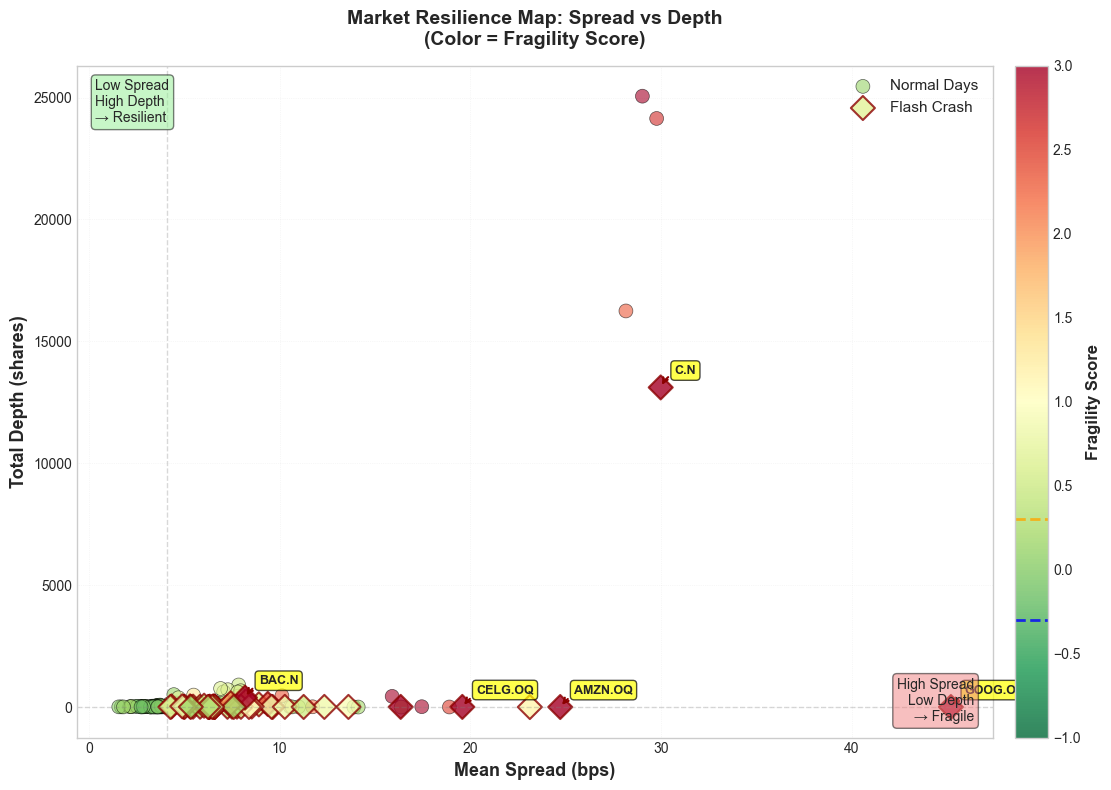

✓ Saved to ../results/method4/market_resilience_map.png

--------------------------------------------------------------------------------
RESILIENCE MAP STATISTICS
--------------------------------------------------------------------------------

Normal Days Liquidity Profile:
  Median Spread: 4.12 bps
  Median Depth:  25 shares
  Spread IQR:    1.52 bps
  Depth IQR:     38 shares

Flash Crash Day Liquidity Profile:
  Median Spread: 7.44 bps
  Median Depth:  12 shares
  Spread IQR:    3.27 bps
  Depth IQR:     16 shares

Quadrant Distribution (relative to normal baseline):
  Normal Days: 67/135 (49.6%) high spread
               67/135 (49.6%) low depth
  Flash Crash: 45/45 (100.0%) high spread
               34/45 (75.6%) low depth

Most Fragile Liquidity Conditions (Flash Crash):
  GOOG.OQ : Spread= 45.21 bps, Depth=       5, Fragility= 6.17
  C.N     : Spread= 29.99 bps, Depth=   13112, Fragility= 3.92
  AMZN.OQ : Spread= 24.72 bps, Depth=       4, Fragility= 3.88
  BAC.N   : Spread=

In [3]:
# Market Resilience Map: Spread vs Depth Analysis
print("\n" + "="*80)
print("MARKET RESILIENCE MAP")
print("="*80)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Prepare data for scatter plot
normal_spread = df_normal_classified['mean_spread'] * 10000  # Convert to bps
normal_depth = df_normal_classified['total_depth']
crash_spread = df_crash_classified['mean_spread'] * 10000
crash_depth = df_crash_classified['total_depth']

# Get fragility scores for color mapping
normal_fragility = df_normal_classified['fragility_score']
crash_fragility = df_crash_classified['fragility_score']

# Create scatter plot with color-coded fragility
scatter_normal = ax.scatter(normal_spread, normal_depth, 
                           c=normal_fragility, cmap='RdYlGn_r', 
                           alpha=0.6, s=100, edgecolors='black', linewidth=0.5,
                           marker='o', label='Normal Days', vmin=-1, vmax=3)

scatter_crash = ax.scatter(crash_spread, crash_depth, 
                          c=crash_fragility, cmap='RdYlGn_r',
                          alpha=0.8, s=150, edgecolors='darkred', linewidth=1.5,
                          marker='D', label='Flash Crash', vmin=-1, vmax=3)

# Add colorbar
cbar = plt.colorbar(scatter_crash, ax=ax, pad=0.02)
cbar.set_label('Fragility Score', fontsize=12, fontweight='bold')
cbar.ax.axhline(y=0.3, color='orange', linewidth=2, linestyle='--', alpha=0.8)
cbar.ax.axhline(y=-0.3, color='blue', linewidth=2, linestyle='--', alpha=0.8)

# Styling
ax.set_xlabel('Mean Spread (bps)', fontsize=13, fontweight='bold')
ax.set_ylabel('Total Depth (shares)', fontsize=13, fontweight='bold')
ax.set_title('Market Resilience Map: Spread vs Depth\n(Color = Fragility Score)', 
             fontsize=14, fontweight='bold', pad=15)

# Add quadrant interpretation
ax.axhline(y=df_normal_classified['total_depth'].median(), 
          color='gray', linestyle='--', alpha=0.3, linewidth=1)
ax.axvline(x=df_normal_classified['mean_spread'].median() * 10000, 
          color='gray', linestyle='--', alpha=0.3, linewidth=1)

# Annotate most fragile crash stocks
top_5_fragile = df_crash_classified.nlargest(5, 'fragility_score')
for idx, row in top_5_fragile.iterrows():
    x_pos = row['mean_spread'] * 10000
    y_pos = row['total_depth']
    ax.annotate(row['ticker'], 
               xy=(x_pos, y_pos), 
               xytext=(10, 10), 
               textcoords='offset points',
               fontsize=9, 
               fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', 
                             color='darkred', lw=1.5))

# Legend
ax.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)

# Add text annotations for quadrants
ax.text(0.02, 0.98, 'Low Spread\nHigh Depth\n→ Resilient', 
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

ax.text(0.98, 0.02, 'High Spread\nLow Depth\n→ Fragile', 
        transform=ax.transAxes, fontsize=10, 
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'market_resilience_map.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved to {OUTPUT_DIR / 'market_resilience_map.png'}")

# Summary statistics
print("\n" + "-"*80)
print("RESILIENCE MAP STATISTICS")
print("-"*80)

print("\nNormal Days Liquidity Profile:")
print(f"  Median Spread: {df_normal_classified['mean_spread'].median()*10000:.2f} bps")
print(f"  Median Depth:  {df_normal_classified['total_depth'].median():.0f} shares")
print(f"  Spread IQR:    {df_normal_classified['mean_spread'].quantile(0.75)*10000 - df_normal_classified['mean_spread'].quantile(0.25)*10000:.2f} bps")
print(f"  Depth IQR:     {df_normal_classified['total_depth'].quantile(0.75) - df_normal_classified['total_depth'].quantile(0.25):.0f} shares")

print("\nFlash Crash Day Liquidity Profile:")
print(f"  Median Spread: {df_crash_classified['mean_spread'].median()*10000:.2f} bps")
print(f"  Median Depth:  {df_crash_classified['total_depth'].median():.0f} shares")
print(f"  Spread IQR:    {df_crash_classified['mean_spread'].quantile(0.75)*10000 - df_crash_classified['mean_spread'].quantile(0.25)*10000:.2f} bps")
print(f"  Depth IQR:     {df_crash_classified['total_depth'].quantile(0.75) - df_crash_classified['total_depth'].quantile(0.25):.0f} shares")

# Quadrant analysis
normal_high_spread = (df_normal_classified['mean_spread'] > df_normal_classified['mean_spread'].median()).sum()
normal_low_depth = (df_normal_classified['total_depth'] < df_normal_classified['total_depth'].median()).sum()
crash_high_spread = (df_crash_classified['mean_spread'] > df_normal_classified['mean_spread'].median()).sum()
crash_low_depth = (df_crash_classified['total_depth'] < df_normal_classified['total_depth'].median()).sum()

print("\nQuadrant Distribution (relative to normal baseline):")
print(f"  Normal Days: {normal_high_spread}/{len(df_normal_classified)} ({normal_high_spread/len(df_normal_classified)*100:.1f}%) high spread")
print(f"               {normal_low_depth}/{len(df_normal_classified)} ({normal_low_depth/len(df_normal_classified)*100:.1f}%) low depth")
print(f"  Flash Crash: {crash_high_spread}/{len(df_crash_classified)} ({crash_high_spread/len(df_crash_classified)*100:.1f}%) high spread")
print(f"               {crash_low_depth}/{len(df_crash_classified)} ({crash_low_depth/len(df_crash_classified)*100:.1f}%) low depth")

# Most extreme stocks
print("\nMost Fragile Liquidity Conditions (Flash Crash):")
worst_5 = df_crash_classified.nlargest(5, 'fragility_score')[['ticker', 'mean_spread', 'total_depth', 'fragility_score']]
for idx, row in worst_5.iterrows():
    print(f"  {row['ticker']:8s}: Spread={row['mean_spread']*10000:6.2f} bps, Depth={row['total_depth']:8.0f}, Fragility={row['fragility_score']:5.2f}")

print("\n✓ Market Resilience Map complete")


REGIME SWITCHING INSPECTION - FLASH CRASH DAY


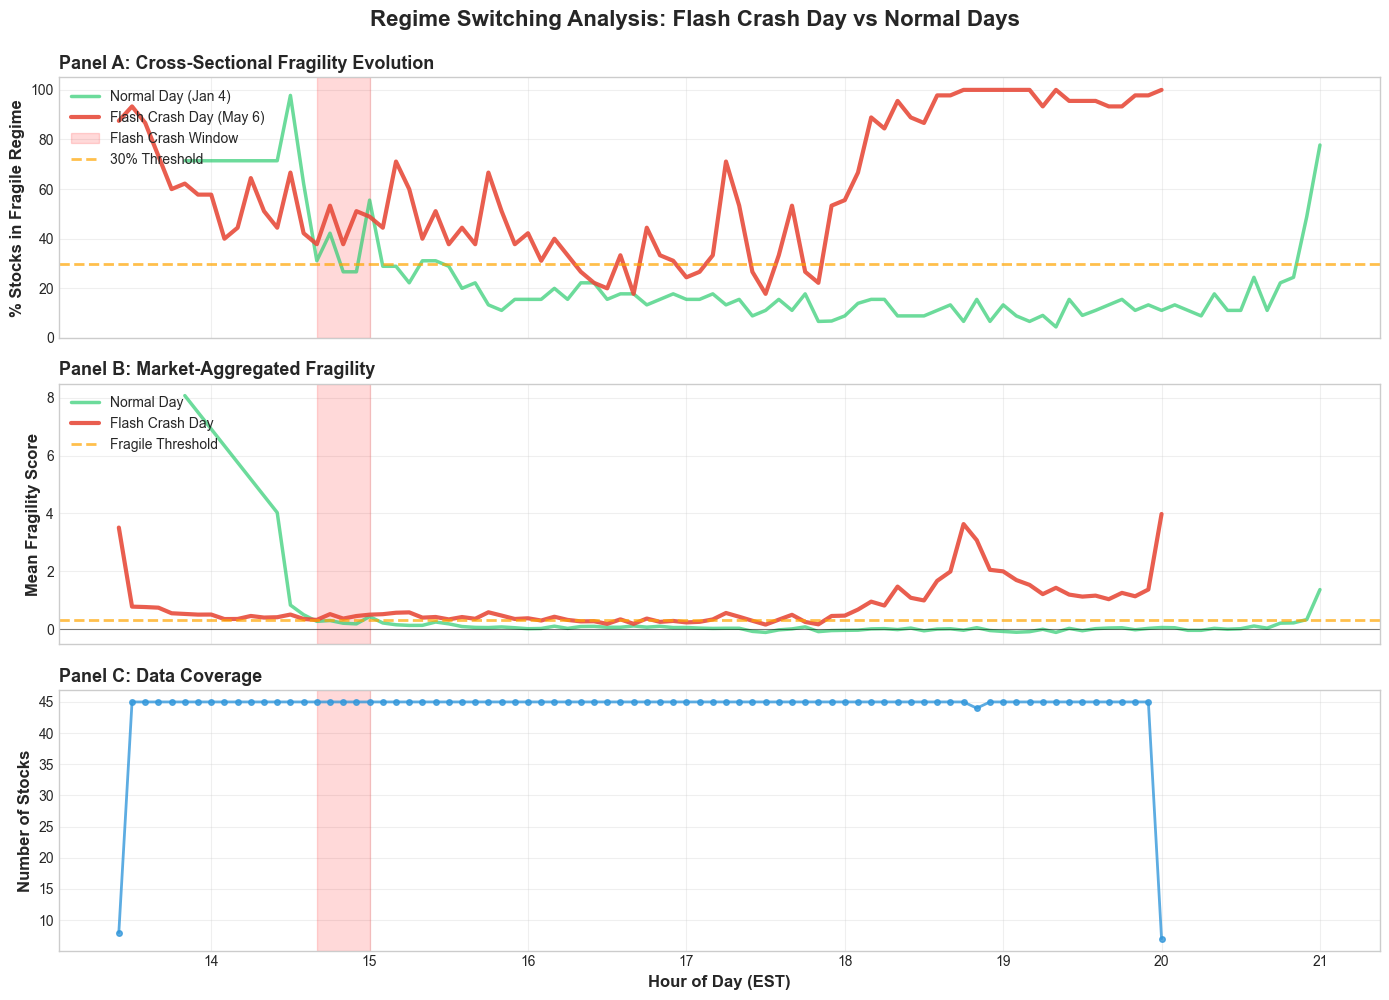

✓ Saved intraday evolution plot


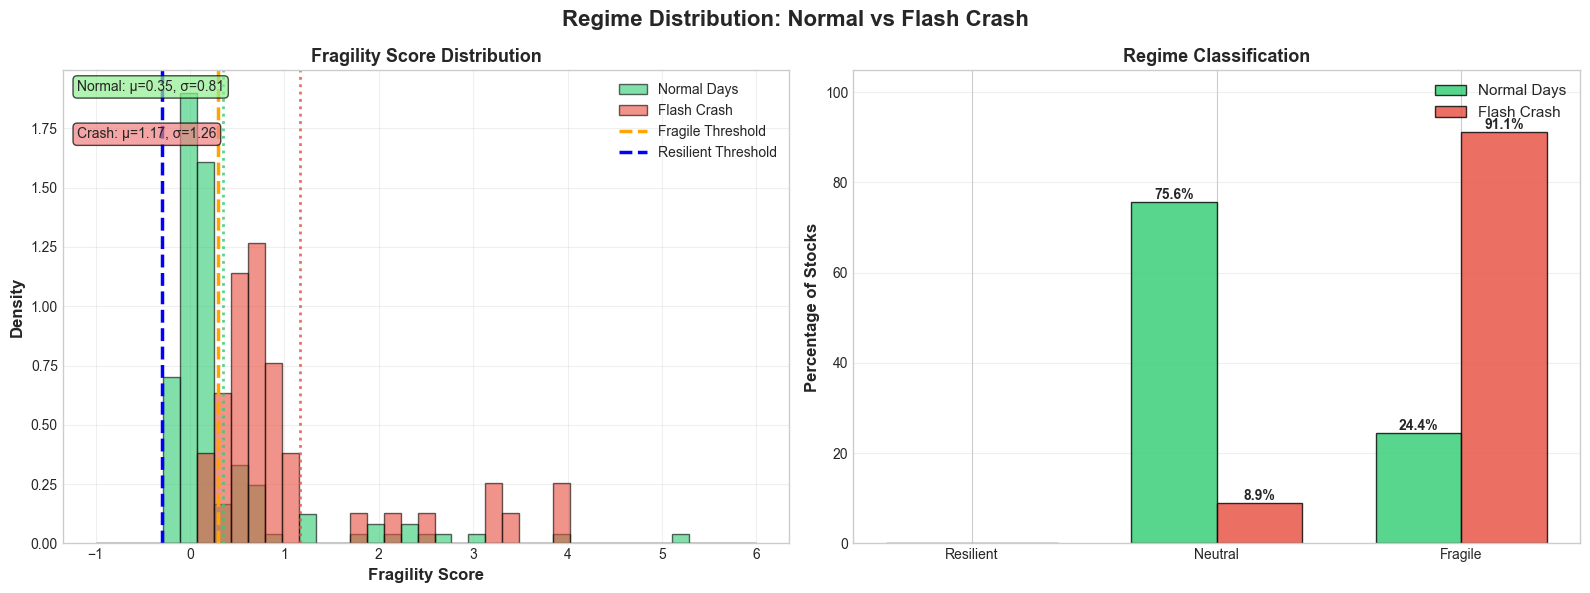

✓ Saved normal vs crash comparison


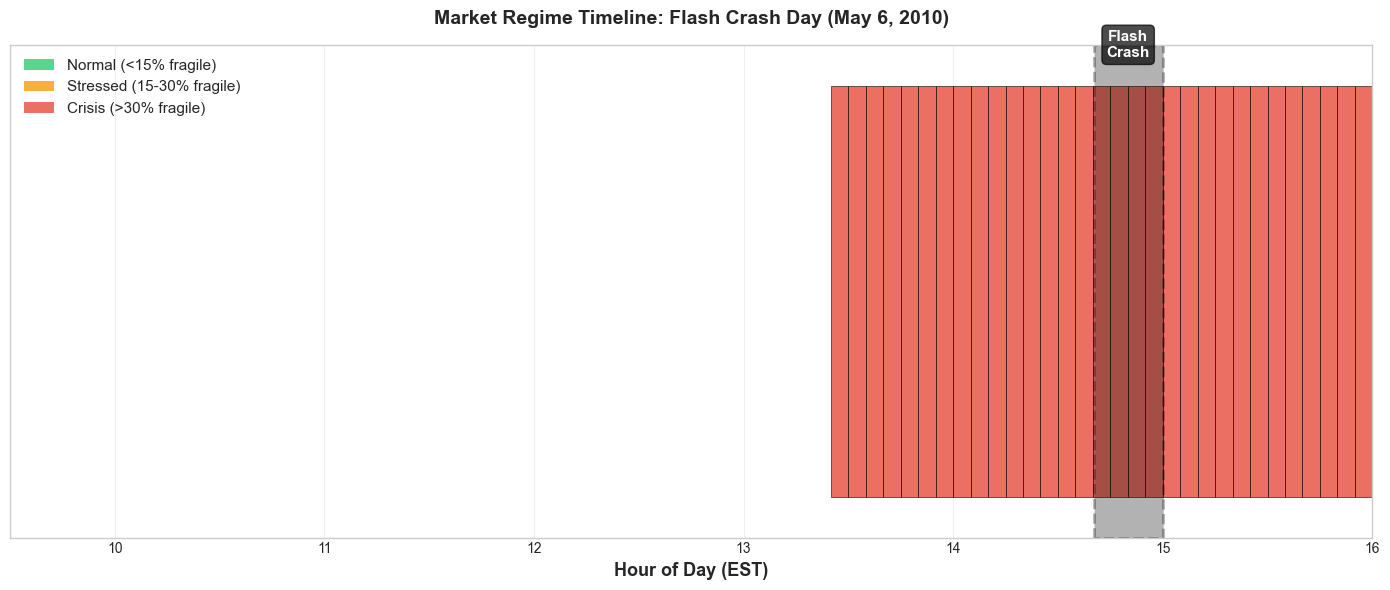

✓ Saved regime timeline

REGIME SWITCHING STATISTICS

1. FLASH CRASH WINDOW (14:40-15:00):
   Mean % Fragile: 45.0%
   Max % Fragile:  53.3%
   Mean Fragility Score: 0.413
   Peak at: 2010-05-06 14:45:00

2. FULL DAY COMPARISON:
   Normal Day Mean % Fragile:  20.5%
   Crash Day Mean % Fragile:   60.6%
   Increase: +40.0 pp

3. REGIME PERSISTENCE:
   Crisis regime windows: 70/80 (87.5%)
   Duration of elevated fragility: 350 minutes

✓ Regime switching inspection complete


In [4]:
# REGIME SWITCHING INSPECTION: Flash Crash Day Analysis
print("\n" + "="*80)
print("REGIME SWITCHING INSPECTION - FLASH CRASH DAY")
print("="*80)

# ==============================================================================
# PLOT 1: Intraday Regime Evolution (like their Figure 1)
# ==============================================================================

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle('Regime Switching Analysis: Flash Crash Day vs Normal Days', 
             fontsize=16, fontweight='bold', y=0.995)

# Panel A: % Fragile Stocks Over Time
ax1 = axes[0]
if df_normal_timeline is not None:
    ax1.plot(df_normal_timeline['timestamp'].dt.hour + df_normal_timeline['timestamp'].dt.minute/60,
             df_normal_timeline['pct_fragile'],
             label='Normal Day (Jan 4)', linewidth=2.5, alpha=0.7, color='#2ecc71')

ax1.plot(df_crash_timeline['timestamp'].dt.hour + df_crash_timeline['timestamp'].dt.minute/60,
         df_crash_timeline['pct_fragile'],
         label='Flash Crash Day (May 6)', linewidth=3, alpha=0.9, color='#e74c3c')

# Mark flash crash window
ax1.axvspan(14.67, 15.0, alpha=0.15, color='red', label='Flash Crash Window')
ax1.axhline(y=30, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='30% Threshold')

ax1.set_ylabel('% Stocks in Fragile Regime', fontsize=12, fontweight='bold')
ax1.set_title('Panel A: Cross-Sectional Fragility Evolution', fontsize=13, fontweight='bold', loc='left')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 105])

# Panel B: Mean Fragility Score
ax2 = axes[1]
if df_normal_timeline is not None:
    ax2.plot(df_normal_timeline['timestamp'].dt.hour + df_normal_timeline['timestamp'].dt.minute/60,
             df_normal_timeline['mean_fragility_score'],
             linewidth=2.5, alpha=0.7, color='#2ecc71', label='Normal Day')

ax2.plot(df_crash_timeline['timestamp'].dt.hour + df_crash_timeline['timestamp'].dt.minute/60,
         df_crash_timeline['mean_fragility_score'],
         linewidth=3, alpha=0.9, color='#e74c3c', label='Flash Crash Day')

ax2.axvspan(14.67, 15.0, alpha=0.15, color='red')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
ax2.axhline(y=0.3, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Fragile Threshold')

ax2.set_ylabel('Mean Fragility Score', fontsize=12, fontweight='bold')
ax2.set_title('Panel B: Market-Aggregated Fragility', fontsize=13, fontweight='bold', loc='left')
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

# Panel C: Number of Stocks Tracked
ax3 = axes[2]
ax3.plot(df_crash_timeline['timestamp'].dt.hour + df_crash_timeline['timestamp'].dt.minute/60,
         df_crash_timeline['total_stocks'],
         linewidth=2, color='#3498db', marker='o', markersize=4, alpha=0.8)

ax3.axvspan(14.67, 15.0, alpha=0.15, color='red')
ax3.set_xlabel('Hour of Day (EST)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Stocks', fontsize=12, fontweight='bold')
ax3.set_title('Panel C: Data Coverage', fontsize=13, fontweight='bold', loc='left')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'regime_inspection_intraday.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved intraday evolution plot")

# ==============================================================================
# PLOT 2: Normal Day vs Crash Day Comparison (like their Figure 2)
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Regime Distribution: Normal vs Flash Crash', fontsize=16, fontweight='bold')

# Left panel: Fragility score distributions
ax1 = axes[0]
bins = np.linspace(-1, 6, 40)
ax1.hist(df_normal_classified['fragility_score'], bins=bins, 
         alpha=0.6, label='Normal Days', color='#2ecc71', density=True, edgecolor='black')
ax1.hist(df_crash_classified['fragility_score'], bins=bins,
         alpha=0.6, label='Flash Crash', color='#e74c3c', density=True, edgecolor='black')

ax1.axvline(x=0.3, color='orange', linestyle='--', linewidth=2.5, label='Fragile Threshold')
ax1.axvline(x=-0.3, color='blue', linestyle='--', linewidth=2.5, label='Resilient Threshold')

# Add statistics
normal_mean = df_normal_classified['fragility_score'].mean()
crash_mean = df_crash_classified['fragility_score'].mean()
ax1.axvline(x=normal_mean, color='#2ecc71', linestyle=':', linewidth=2, alpha=0.8)
ax1.axvline(x=crash_mean, color='#e74c3c', linestyle=':', linewidth=2, alpha=0.8)

ax1.text(0.02, 0.98, f'Normal: μ={normal_mean:.2f}, σ={df_normal_classified["fragility_score"].std():.2f}',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))
ax1.text(0.02, 0.88, f'Crash: μ={crash_mean:.2f}, σ={df_crash_classified["fragility_score"].std():.2f}',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))

ax1.set_xlabel('Fragility Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Density', fontsize=12, fontweight='bold')
ax1.set_title('Fragility Score Distribution', fontsize=13, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Right panel: Regime breakdown
ax2 = axes[1]
normal_counts = df_normal_classified['regime'].value_counts()
crash_counts = df_crash_classified['regime'].value_counts()

# Ensure all regimes present
regime_order = ['Resilient', 'Neutral', 'Fragile']
normal_pcts = [normal_counts.get(r, 0) / len(df_normal_classified) * 100 for r in regime_order]
crash_pcts = [crash_counts.get(r, 0) / len(df_crash_classified) * 100 for r in regime_order]

x = np.arange(len(regime_order))
width = 0.35

bars1 = ax2.bar(x - width/2, normal_pcts, width, label='Normal Days', 
                color='#2ecc71', alpha=0.8, edgecolor='black')
bars2 = ax2.bar(x + width/2, crash_pcts, width, label='Flash Crash',
                color='#e74c3c', alpha=0.8, edgecolor='black')

# Add percentage labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_ylabel('Percentage of Stocks', fontsize=12, fontweight='bold')
ax2.set_title('Regime Classification', fontsize=13, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(regime_order)
ax2.legend(loc='upper right', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim([0, max(max(normal_pcts), max(crash_pcts)) * 1.15])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'regime_comparison_normal_vs_crash.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved normal vs crash comparison")

# ==============================================================================
# PLOT 3: Regime Persistence Analysis (transition dynamics)
# ==============================================================================

if df_crash_timeline is not None and len(df_crash_timeline) > 1:
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    
    # Create regime categories based on % fragile
    df_crash_timeline['regime_label'] = pd.cut(df_crash_timeline['pct_fragile'],
                                                bins=[0, 15, 30, 100],
                                                labels=['Normal', 'Stressed', 'Crisis'])
    
    # Plot as colored bars
    colors_map = {'Normal': '#2ecc71', 'Stressed': '#f39c12', 'Crisis': '#e74c3c'}
    
    for i in range(len(df_crash_timeline)-1):
        start_time = df_crash_timeline.iloc[i]['timestamp'].hour + df_crash_timeline.iloc[i]['timestamp'].minute/60
        end_time = df_crash_timeline.iloc[i+1]['timestamp'].hour + df_crash_timeline.iloc[i+1]['timestamp'].minute/60
        regime = df_crash_timeline.iloc[i]['regime_label']
        pct = df_crash_timeline.iloc[i]['pct_fragile']
        
        ax.barh(y=0, width=end_time-start_time, left=start_time, height=0.5,
               color=colors_map[regime], alpha=0.8, edgecolor='black', linewidth=0.5)
    
    # Add crash window marker
    ax.axvspan(14.67, 15.0, alpha=0.3, color='black', linestyle='--', linewidth=2)
    ax.text(14.835, 0.3, 'Flash\nCrash', ha='center', va='center', 
           fontsize=11, fontweight='bold', color='white',
           bbox=dict(boxstyle='round', facecolor='black', alpha=0.7))
    
    # Create legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=colors_map['Normal'], label='Normal (<15% fragile)', alpha=0.8),
                      Patch(facecolor=colors_map['Stressed'], label='Stressed (15-30% fragile)', alpha=0.8),
                      Patch(facecolor=colors_map['Crisis'], label='Crisis (>30% fragile)', alpha=0.8)]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=11)
    
    ax.set_xlim([9.5, 16])
    ax.set_ylim([-0.3, 0.3])
    ax.set_xlabel('Hour of Day (EST)', fontsize=13, fontweight='bold')
    ax.set_title('Market Regime Timeline: Flash Crash Day (May 6, 2010)', 
                fontsize=14, fontweight='bold', pad=15)
    ax.set_yticks([])
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'regime_timeline_colored.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved regime timeline")

# ==============================================================================
# Summary Statistics
# ==============================================================================

print("\n" + "="*80)
print("REGIME SWITCHING STATISTICS")
print("="*80)

print("\n1. FLASH CRASH WINDOW (14:40-15:00):")
crash_window = df_crash_timeline[
    (df_crash_timeline['timestamp'].dt.hour == 14) & 
    (df_crash_timeline['timestamp'].dt.minute >= 40)
]
if len(crash_window) > 0:
    print(f"   Mean % Fragile: {crash_window['pct_fragile'].mean():.1f}%")
    print(f"   Max % Fragile:  {crash_window['pct_fragile'].max():.1f}%")
    print(f"   Mean Fragility Score: {crash_window['mean_fragility_score'].mean():.3f}")
    print(f"   Peak at: {crash_window.loc[crash_window['pct_fragile'].idxmax(), 'timestamp']}")

print("\n2. FULL DAY COMPARISON:")
print(f"   Normal Day Mean % Fragile:  {df_normal_timeline['pct_fragile'].mean():.1f}%")
print(f"   Crash Day Mean % Fragile:   {df_crash_timeline['pct_fragile'].mean():.1f}%")
print(f"   Increase: {df_crash_timeline['pct_fragile'].mean() - df_normal_timeline['pct_fragile'].mean():+.1f} pp")

print("\n3. REGIME PERSISTENCE:")
crisis_windows = (df_crash_timeline['pct_fragile'] > 30).sum()
total_windows = len(df_crash_timeline)
print(f"   Crisis regime windows: {crisis_windows}/{total_windows} ({crisis_windows/total_windows*100:.1f}%)")
print(f"   Duration of elevated fragility: {crisis_windows*5:.0f} minutes")

print("\n✓ Regime switching inspection complete")